# Auxiliar 11: Two point correlation function de nubes de puntos

Por Javiera Toro Grey para el curso AS4501: Astroinformática, Otoño 2025.

Se nos pide analizar la distribución espacial del campo de UNCOVER/JWST.

Este campo está centrado en un cúmulo galáctico llamado ABELL 2744, por lo que esperamos que el análisis espacial muestre clustering.

Abell 2744, apodado como Cúmulo de Pandora, es un cúmulo de galaxias gigantes resultado del apilamiento simultáneo de cuando menos cuatro cúmulos de galaxias menores separados, que tuvo lugar durante un intervalo de 350 millones de años.

FUNFACT: Solo el 5% de la masa del cúmulo proviene de galaxias, 20% es gas caliente solo visible en rayos X y el sigueitne 75% es materia oscura!!

In [1]:
# Deopendencias

from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import astropy.units as u
import seaborn as sns


Revisemos el catálogo de UNCOVER:

In [2]:
path = '/Users/javieratoro/Desktop/TA/Astroinformatics/UNCOVER_DR1_LW_D032_catalog.fits'
OR_cat = fits.open(path)[1].data
OR_cat

FITS_rec([(    1,  1541.34403549,   324.50505105, 3.65176813, -30.443812  , 0.0102823 , 170.30920609, 1.24736131, nan, nan, nan, nan, nan,        nan, 434.60109215, 5.29702742, 0.0035371 , nan, nan, nan, nan, nan, nan,  5.45520590e+02, 4.74204054, 0.00183934, nan, nan, nan, nan, nan, nan, 699.96079144, 4.3817788 , 0.00279387, nan, nan, nan, 833.59057541, 4.25702331, 0.00279387, 790.45035259, 4.32039152, 0.00143198, 510.97034435, 3.10374322, 0.00221893, nan, nan, nan, 502.33762004, 3.67916993, 0.00197342, 0.33903335, 3.5       , 0.77634053,  5.83516741, 5.26981211,  0.19027472, 0.20257705, 1, 0, 0, 0, 0, 0, 0, -1.,      7,  0.35122582,  0.61256313, 0.23813756,  0.29096803,  0.3481643,  0.4143877,  0.47171447, 497.54794  , 4.2670420e+03, 305.35028  , 1.0450342e+03, 376.66946  , 43.549957  , 753.30914  , 43.048553  , 3.5574850e+02, 3.998257e+03, 308.8158  , 9.3419293e+02, 473.93262 , 102.42253   , 89.17148 , 1.       , 1.       , 1.       , 1.       , 1.       ),
          (    2,  1627.9

Queremos la distribución espacial, asi que veamos las coordenadas

In [3]:
x, y = OR_cat['ra'], OR_cat['dec']

coords = np.vstack([x, y]).T

x_range = x.max() - x.min()
y_range = y.max() - y.min()
area = x_range * y_range


Visualicemos esto:

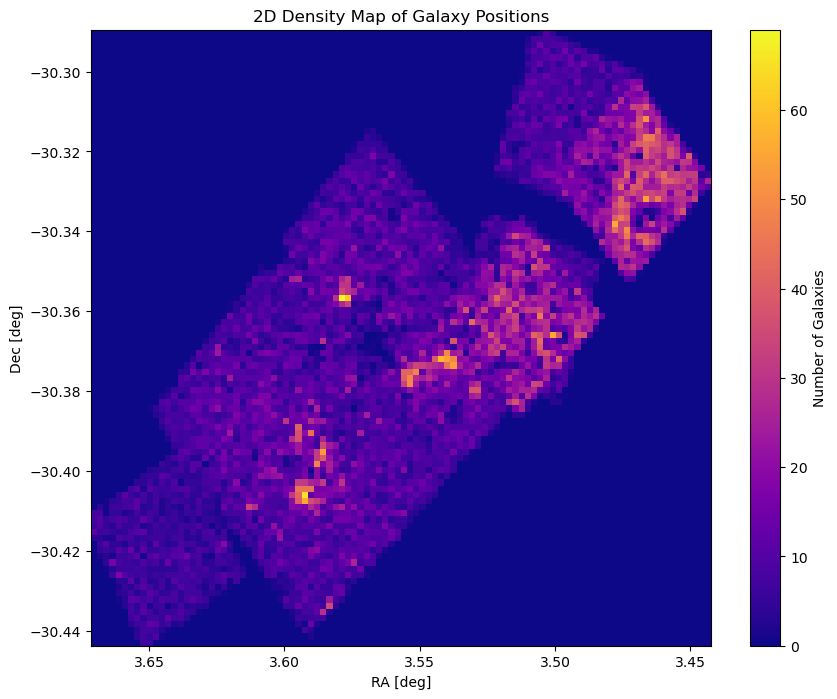

In [4]:

plt.figure(figsize=(10, 8))

h = plt.hist2d(x, y, bins=100, cmap='plasma')
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("2D Density Map of Galaxy Positions")
plt.colorbar(label='Number of Galaxies')
plt.gca().invert_xaxis()


Queremos revisar que tan agrupadas están las galaxias, para esto usaremos la función G, y la Two-point correlation para estudiarlo.

¿Por qué?

Estas herramientas nos permiten cuantificar cuán agrupadas o distribuidas al azar están las galaxias en el plano del cielo, lo cual nos entrega información clave sobre la formación de estructuras a gran escala y los procesos físicos que rigen la evolución de galaxias.

1. Función G(r) (o función de distribución de vecinos más cercanos):

	•	Nos dice la probabilidad acumulada de que una galaxia tenga su vecina más cercana a una distancia menor o igual que r.

	•	Si G(r) crece más rápido que el caso aleatorio (Poisson), indica agrupamiento a pequeña escala.
	
	•	Si crece más lento, indica dispersión o regularidad en la distribución.

Es ideal para detectar grupos compactos, filamentos densos o vacíos. Podemos estudiar pares de galaxias, grupos muy pequeños!!

In [5]:
def compute_g_function(x, y, A, bins=40):
    points = np.vstack([x, y]).T
    tree = cKDTree(points)
    nn_distances, _ = tree.query(points, k=2)
    nn_distances = nn_distances[:, 1]

    counts, bin_edges = np.histogram(nn_distances, bins=bins, density=True)
    cdf = np.cumsum(counts) * np.diff(bin_edges)
    r = bin_edges[:-1]
    lam = len(x) / A
    G_theory = 1 - np.exp(-np.pi * lam * r**2)
    return r, cdf, G_theory, nn_distances

Para visualizar la G-Function, usaremos un MC envelope (CSR: Complete Spatial Randomness**), asi revisamos la agrupacion a pequeñas escalas

**CSR es la hipótesis nula en estadística espacial. Esta asume que los objetos (como las galaxias) están distribuidos de manera aleatoria e independiente sobre una región, con probabilidad uniforme en todo el campo.

In [11]:
def g_function_monte_carlo(xmin, xmax, ymin, ymax, n_points, area, bins, n_sim=100):
    sims = []
    for _ in range(n_sim):
        rx = np.random.uniform(xmin, xmax, n_points)
        ry = np.random.uniform(ymin, ymax, n_points)
        r, g_emp, g_theo, _ = compute_g_function(rx, ry, area, bins=bins)
        sims.append(g_emp)
    sims = np.array(sims)
    g_low = np.percentile(sims, 5, axis=0)
    g_high = np.percentile(sims, 95, axis=0)
    return r, g_low, g_high

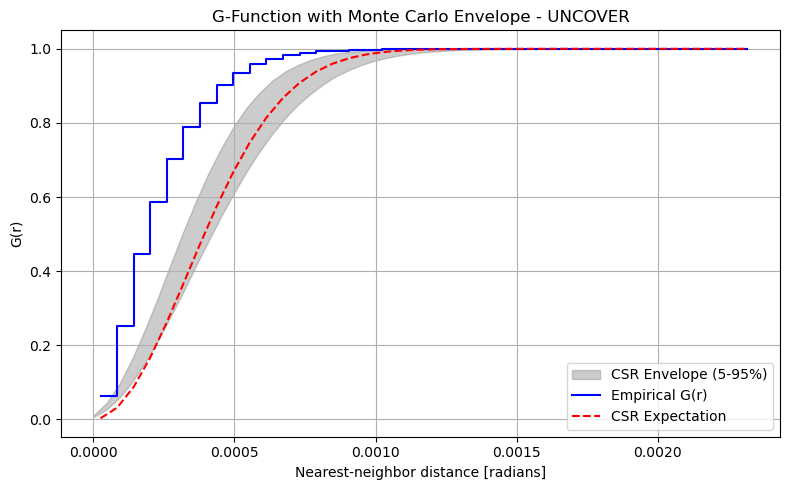

In [12]:
r_vals, g_empirical, g_theory, nn_distances = compute_g_function(x, y, area)
r_env, g_lo, g_hi = g_function_monte_carlo(x.min(), x.max(), y.min(), y.max(),
                                           len(x), area, bins=40, n_sim=1000)

# Plot G-function with envelope
plt.figure(figsize=(8, 5))
plt.fill_between(r_env, g_lo, g_hi, color='gray', alpha=0.4, label='CSR Envelope (5-95%)')
plt.plot(r_vals, g_empirical, label="Empirical G(r)", drawstyle='steps-post', color='blue')
plt.plot(r_vals, g_theory, label="CSR Expectation", linestyle='--', color='red')
plt.xlabel("Nearest-neighbor distance [radians]")
plt.ylabel("G(r)")
plt.title("G-Function with Monte Carlo Envelope - UNCOVER")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

El plot muestra que la G(r) empirica, esta sobre el CSR envelope (MC), lo que sugiere clustering a pequeñas escalas!!!!

Esto significa que las galaxias estan mas juntas de lo esperado por una distribución random de Poisson. Lo que tiene sentido con la formación de grandes estructuras en alto redshift

Revisemos ahora la Two-point correlation:

2. Función de correlación a dos puntos ξ(r):

	•	Mide el exceso de probabilidad de encontrar pares de galaxias a una separación r, en comparación con una distribución completamente aleatoria.

	•	Si $\xi(r) > 0$, hay agrupamiento; si $\xi(r) = 0$, hay distribución aleatoria; y si $\xi(r) < 0$, hay repulsión (inusual).

	•	Se calcula usando el estimador de Landy–Szalay, que minimiza errores y sesgos de borde.

Así $\xi(r)$ describe la estructura a todas las escalas, desde pares cercanos hasta agrupaciones grandes.

¿Por qué usamos el estimador de Landy–Szalay?
Por sus grandes ventajas en el manejo de las imagenes!!

1. Corrige efectos de borde
En campos de observación limitados (como imágenes del cielo), no se pueden contar pares de galaxias que caen fuera del borde. El estimador de Landy–Szalay **minimiza este error**, comparando con un catálogo aleatorio que simula una distribución aleatoria completa (CSR).

 2. Reduce la varianza estadística
Tiene **menos ruido** que otros estimadores clásicos como:
- $ \xi = \frac{DD}{RR} - 1  $

- $ \xi = \frac{DD - DR}{RR} $

Porque combina tres tipos de conteos de pares:

- **DD**: pares entre galaxias reales  
- **RR**: pares entre puntos aleatorios  
- **DR**: pares cruzados entre galaxias y puntos aleatorios

$
\xi(r) = \frac{DD - 2DR + RR}{RR}
$

Revisemos:

In [ ]:
def count_pairs(data1, data2, bins):
    tree1 = cKDTree(data1)
    tree2 = cKDTree(data2)
    counts = np.zeros(len(bins) - 1)
    for i, pt in enumerate(data1):
        dists = tree2.query_ball_point(pt, r=bins[-1])
        for j in dists:
            if data1 is data2 and j <= i: continue
            dist = np.linalg.norm(pt - data2[j])
            idx = np.searchsorted(bins, dist) - 1
            if 0 <= idx < len(counts):
                counts[idx] += 1
    return counts



def landy_szalay_2pcf(coords, bins, rand_mult=5):
    n_data = len(coords)
    rand_coords = np.random.uniform(
        [x.min(), y.min()],
        [x.max(), y.max()],
        size=(n_data * rand_mult, 2)
    )
    DD = count_pairs(coords, coords, bins)
    RR = count_pairs(rand_coords, rand_coords, bins)
    DR = count_pairs(coords, rand_coords, bins)

    DD = DD / (n_data * (n_data - 1) / 2)
    RR = RR / (len(rand_coords) * (len(rand_coords) - 1) / 2)
    DR = DR / (n_data * len(rand_coords))

    xi = (DD - 2 * DR + RR) / RR
    return xi

Sabemos que la imagen de UNCOVER cubre 45 arcmin cuadrados, lo que implica que la máxima separación entre las galaxias puede ser 0.002 radianes (6.7 arcmin). Revisemos entonces como seria la probabilidad de encontrar galaxias en distancias desde 0.0005 a 0.002 radianes (1.7 a 6.7 arcmin)

In [19]:
r_bins = np.linspace(0.0005, 0.002, 30)
r_cent = 0.5 * (r_bins[:-1] + r_bins[1:])
xi = landy_szalay_2pcf(coords, r_bins)

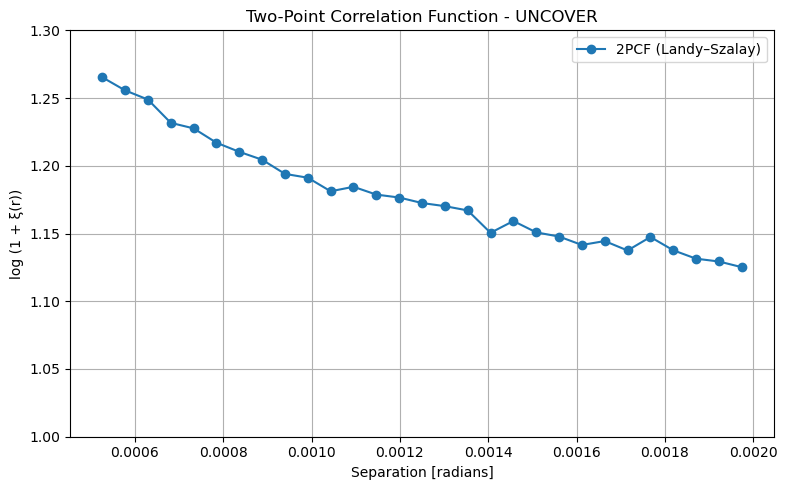

In [24]:
# Plot 2PCF
plt.figure(figsize=(8, 5))
plt.plot(r_cent, np.log(1 + xi), 'o-', label='2PCF (Landy–Szalay)')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Separation [radians]")
plt.ylabel("log (1 + ξ(r))")
plt.ylim(1, 1.3)
plt.title("Two-Point Correlation Function - UNCOVER")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Esto implica que hay un probabilidad de clustering muy alta en todas las direcciones y distancias de la imagen. Lo cual tiene sentido, estamos observando un cluster!!!

¿Por qué esperar valores altos de ξ(r)ξ(r) en Abell 2744?

1 .- Es un cúmulo muy masivo:

La densidad de galaxias es mucho mayor que la del fondo cósmico.

Esto produce un exceso claro de pares de galaxias a pequeñas separaciones → $\xi(r) > 0$, incluso $\xi > 1$ o 10 a pequeñas escalas.

2 .- Estructura subcompleja (colisiones):

Tiene subestructuras (4 subcúmulos), lo que refuerza el clustering.

Es probable ver peaks o subestructuras en la función de correlación.

3 .- Ambiente denso:

Cúmulos como Abell 2744 tienen muchos pares de galaxias dentro de escalas pequeñas (<1 Mpc), lo que genera una señal clara en $\xi$.

Que tengan un buen fin de semestre!!!!

**Javivi**